**Основная задача:** Подготовить исследование рынка, для открытия кафе в Москве, где в качестве обслуживающего персонала являются роботы. 

Имеются данные о заведениях общественного питания Москвы.

Этапы достижения основной задачи:
- загрузить данные и подготовьте их к анализу;
- проанализировать данные;
- подготовить презентацию.

# Шаг №1.  Загрузить данные и подготовить их к анализу

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

Структура **DF**:
- **id** — идентификатор объекта;
- **object_name** — название объекта общественного питания;
- **chain** — сетевой ресторан;
- **object_type** — тип объекта общественного питания;
- **address** — адрес;
- **number** — количество посадочных мест.

In [2]:
df = pd.read_csv('rest_data.csv')

Проверим данные на наличие пропусков и типа данных:

In [3]:
report = df.isna().sum().to_frame()
report = report.rename(columns={0: 'null_values'})
report['% of total'] = (report['null_values'] * 100 / df.shape[0]).round(1)
report['type'] = str(df.columns.dtype)
report.sort_values(by='null_values', ascending=False)
report.style.background_gradient(subset=['null_values'])

,null_values,% of total,type
id,0,0.000000,object
object_name,0,0.000000,object
chain,0,0.000000,object
object_type,0,0.000000,object
address,0,0.000000,object
number,0,0.000000,object


In [4]:
df.isna().mean().reset_index()

,index,0
0,id,0.0
1,object_name,0.0
2,chain,0.0
3,object_type,0.0
4,address,0.0
5,number,0.0


In [5]:
# оценив данные, создадим пайплайн для загрузки полного датасета:
df = pd.read_csv('rest_data.csv',
                 names=['id', 'object_name', 'chain', 'object_type', 'address', 'number'], header=0,
                 dtype={'id': 'int64', 'number': 'int16'}
                 )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int16 
dtypes: int16(1), int64(1), object(4)
memory usage: 630.4+ KB


**Вывод:** Уменьшили размер DF.

Убедимся в наличие(отстутствие) дубликатов, при этом удалим столбец id, который нигде не фигурирует:

In [6]:
df[['object_name','address','chain','object_type','address','number']].duplicated().sum()

82

Имеются 82 дублика, которые можно удалить:

In [7]:
df = df.drop_duplicates(subset=['object_name', 'address',
                                'chain', 'object_type', 'address', 'number'], keep='last')

**Вывод:** Данные DF преведены в необходимый тип данных, тем самым уменьшили размер DF. Убедились в наличии 82 дубликатов и удалили их.

# Шаг №2. Анализ данных

## Cоотношение видов объектов общественного питания по количеству

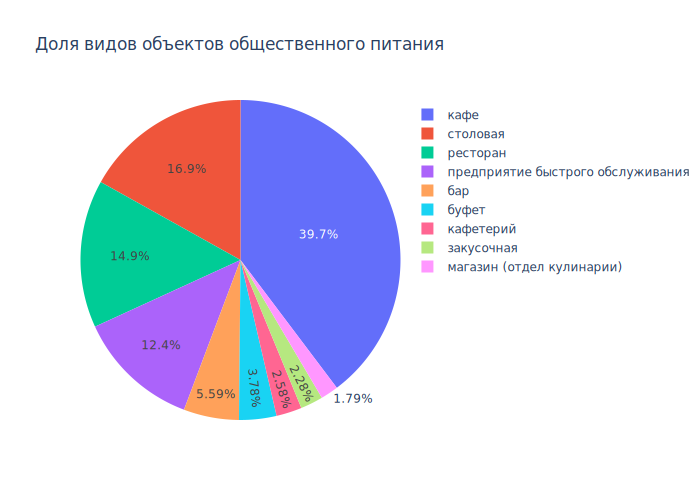

In [8]:
data_object_type = df.groupby('object_type').agg({'id': 'count'}).reset_index()
data_object_type['count'] = data_object_type['id'] / len(df)
fig = go.Figure(data=[go.Pie(
    labels=data_object_type['object_type'], values=data_object_type['count'])])
fig.update_layout(title='Доля видов объектов общественного питания')
fig.show("svg")

**Вывод:** Большую долю - 39.7% исследуемых данных составляют кафе, столовые - 16.9%, ресторан - 14.9%, предприятия быстрого обслуживания - 12.4%.

## Cоотношение сетевых и несетевых заведений по количеству

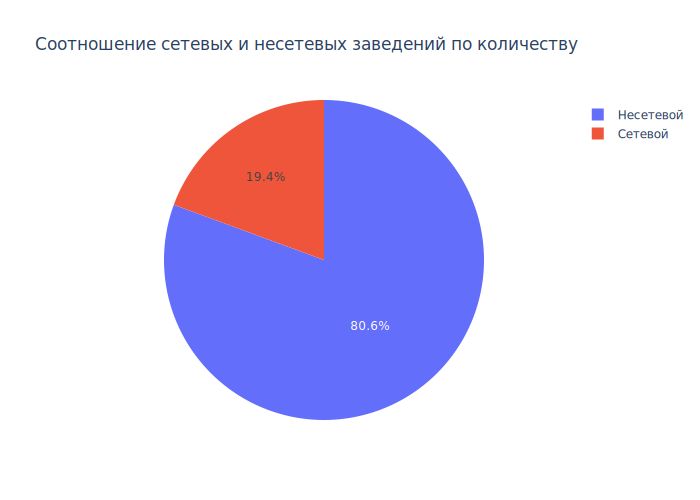

In [9]:
data_chain = df.groupby('chain').agg({'id': 'count'}).reset_index()
data_chain['name'] = ['Сетевой', 'Несетевой']
data_chain['count'] = data_chain['id'] / len(df)
fig = go.Figure(
    data=[go.Pie(labels=data_chain['name'], values=data_chain['count'])])
fig.update_layout(
    title='Cоотношение сетевых и несетевых заведений по количеству')
fig.show("svg")

**Вывод:** 80.6% данных составляют несетевые магазины и 19.4% сетевые.

## Виды объекта общественного питания сетевого характера:

In [10]:
# Сделаем срез данных:
object_types = df.groupby('object_type', as_index=False).agg(
    {'object_name': 'count'}).sort_values(by='object_name', ascending=False)

chain_object_types = df[df['chain'] == 'да'].groupby('object_type', as_index=False).agg(
    {'object_name': 'count'}).sort_values(by='object_name', ascending=False)

chain_object_types = chain_object_types.merge(object_types[['object_type', 'object_name']],
                                              left_on='object_type', right_on='object_type')

chain_object_types.columns = ['object_type', 'chain_objects', 'all_objects']
# Рассчетаем долю сетевых заведений от общего числа в каждом виде заведения:
chain_object_types['percent'] = (
    chain_object_types['chain_objects'] / chain_object_types['chain_objects'].sum()*100).round(1).astype('str')+'%'

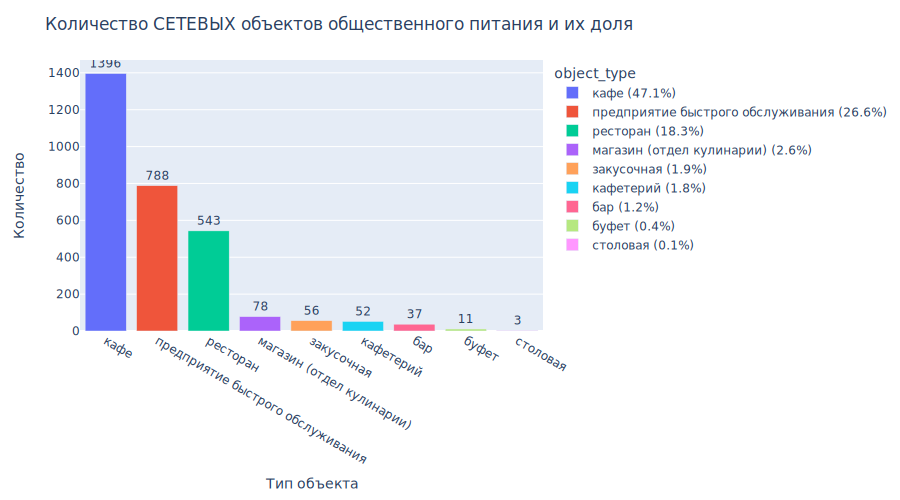

In [11]:
fig = px.bar(chain_object_types, x='object_type', y='chain_objects',
             color='object_type', text='chain_objects', width=900)
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Количество СЕТЕВЫХ объектов общественного питания и их доля',
    xaxis_title="Тип объекта",
    yaxis_title="Количество")
fig.update_traces(textposition='outside')
for trace, percent in zip(fig.data, chain_object_types['percent']):
    trace.name = trace.name.split('=')[0] + ' (' + percent + ')'
fig.show("svg")

**Вывод:** Как мы видим из диаграммы, наибольшее количество типов СЕТЕВЫХ объектов составляют:
кафе 47.1%, предприятия быстро обслуживания 26.6%, рестораны 18.3%.


## Характерные условия для сетевых заведений(много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест)

In [12]:
chain_objects = df[df['chain'] == 'да'].groupby('object_name').agg(
    {'object_name': 'count', 'number': 'median'}
)
chain_objects.columns = ['objects', 'median_number']

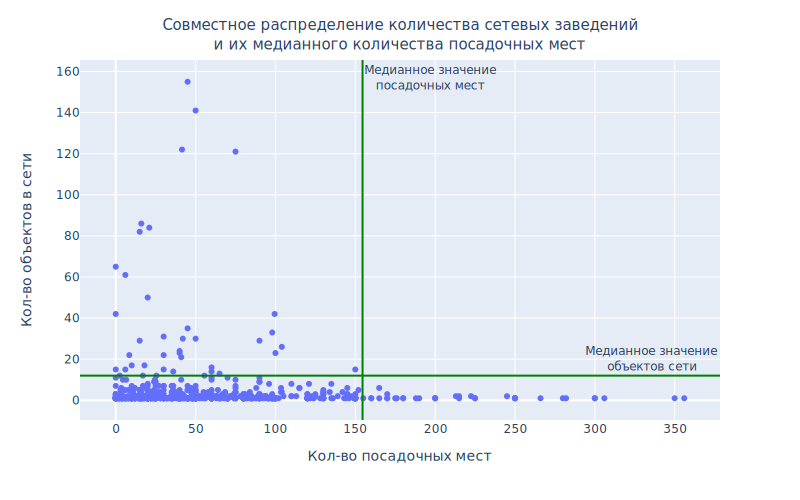

In [13]:
fig = px.scatter(chain_objects, y="objects", x="median_number", width = 800)
fig.update_layout(
    title=dict(
        text='Совместное распределение количества сетевых заведений' + '<br>' + 'и их медианного количества посадочных мест',
        x=0.5,
        font=dict(size=15)),
    xaxis_title="Кол-во посадочных мест",
    yaxis_title="Кол-во объектов в сети")
fig.add_vline(
    x=np.percentile(chain_objects['median_number'], 95),
    line_width=2,
    line_color="green",
    annotation_text="Медианное значение" + '<br>' + 'посадочных мест'
)
fig.add_hline(
    y=np.percentile(chain_objects['objects'], 95),
    line_width=2,
    line_color="green",
    annotation_text="Медианное значение" + '<br>' + 'объектов сети'
)
fig.show("svg")


**Вывод:** Как мы видим из графика, как правило, в сетевых заведениях - мало заведений с большим количеством посадочных мест.
В 95% сетей не больше 154 посадочных мест и 12 заведений.

## Для каждого вида объекта общественного питания опишем среднее количество посадочных мест

Выполним группировку по видам объекта и рассчитаем медианное значение посадочных мест в каждом виде заведения:

In [14]:
object_types_number_mean = df.groupby('object_type', as_index=False).agg(
    {'number':'mean'}).sort_values(by='number', ascending=False).round()
object_types_number_mean['number'] = object_types_number_mean['number'].astype('int')

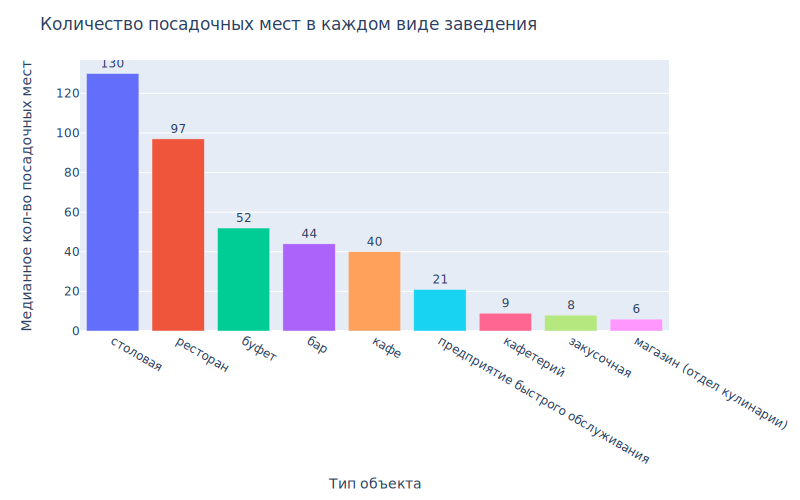

In [15]:
fig = px.bar(object_types_number_mean, x='object_type', y='number',
             color='object_type', text='number', width=800)
fig.update_xaxes(tickangle=30)
fig.update_layout(
    title='Количество посадочных мест в каждом виде заведения',
    xaxis_title="Тип объекта",
    yaxis_title="Медианное кол-во посадочных мест")
fig.update_traces(textposition='outside')
fig.update(layout_showlegend=False)
fig.show("svg")

**Вывод:** Максимальное количество посадочных мест характерно для столовых - 130 мест, у ресторанов 97 мест. У остальных значительно меньшее количество. 

## Выделите в отдельный столбец информацию об улице из столбца address:

In [16]:
street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе',
                'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']


def street_finder(address):
    # Раздробим строку на части по запятой:
    for address_part in address.split(', '):
        for street_type in street_types:
            # Найдем совпадение
            if address_part.lower().find(street_type) != -1:
                return address_part


df['street'] = df['address'].apply(street_finder)
df.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


**Вывод:** В общую таблицу добавили столбец с названием улицы.

## График топ-10 улиц по количеству объектов общественного питания:

Загрузим данные всех улиц Москвы и их привязка к районам с сайта МосГаз

In [17]:
district = pd.read_csv('mosgaz-streets.csv')

Сгрупперуем данные по улицам и посчитаем количество заведений, расположенных на них.

In [18]:
top_streets = df.groupby('street', as_index=False).agg(
    {'object_name': 'count'})
top_streets.columns = ['street', 'objects']
top_streets = top_streets.sort_values(by='objects', ascending=False)
top10_streets = top_streets.head(10).reset_index(drop=True)

Создадим список из топ-10 улиц:

In [19]:
top10_streets_list = top10_streets['street'].to_list()

Сделаем выборку из исходных данных с топ-10 улицами:

In [20]:
top10 = df.query('street in @top10_streets_list')

Смержим данные топ10 улиц с данными об улицах Москвы и их привязка к районам с сайта МосГаз:

In [21]:
top10 = top10.merge(district[['area','streetname']], left_on='street', right_on='streetname')

Построим график топ-10 улиц с наибольшим количеством заведений:

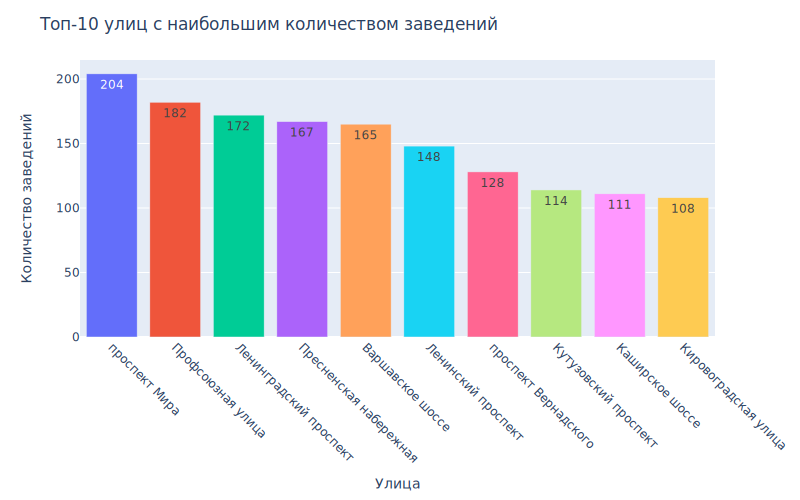

In [22]:
fig = px.bar(top10_streets, x='street', y='objects',
             color='street', text='objects', width=800)
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title='Топ-10 улиц с наибольшим количеством заведений',
    xaxis_title="Улица",
    yaxis_title="Количество заведений")
fig.update(layout_showlegend=False)
for trace in fig.data:
    trace.name = trace.name.split('=')[0]
fig.show("svg")

Список районов, через которые проходят топ-10 улиц с максимальным количеством заведений:

In [23]:
top10.groupby(['street', 'area']).agg({'id':'count'}).sort_values('id', ascending = False)

id
street                 area                                
проспект Мира          Ярославский Район                204
                       Район Свиблово                   204
                       Район Ростокино                  204
                       Район Марьина роща               204
                       Останкинский район               204
                       Мещанский район                  204
                       Алексеевский район               204
Профсоюзная улица      Район Коньково                   182
                       Академический район              182
                       Обручевский район                182
                       Район Черемушки                  182
                       Район Теплый Стан                182
                       Район Ясенево                    182
Ленинградский проспект Район Сокол                      172
                       Хорошевский район                172
                       Район Аэропорт                   172
                       Район Беговой                    172
Пресненская набережная Пресненский район                167
Варшавское шоссе       Нагорный район                   165
                       Донской район                    165
                       Район Северное Бутово            165
                       Район Южное Бутово               165
                       Район Нагатино-Садовники         165
                       Район Чертаново Южное            165
                       Район Чертаново Центральное      165
                       Район Чертаново Северное         165
Ленинский проспект     Район Якиманка                   148
                       Донской район                    148
                       Район Гагаринский                148
                       Район Тропарево-Никулино         148
                       Район Теплый Стан                148
                       Район Проспект Вернадского       148
                       Обручевский район                148
                       Ломоносовский район              148
проспект Вернадского   Район Раменки                    128
                       Район Тропарево-Никулино         128
                       Ломоносовский район              128
                       Район Гагаринский                128
                       Район Проспект Вернадского       128
Кутузовский проспект   Район Фили-Давыдково             114
                       Район Дорогомилово               114
Каширское шоссе        Район Москворечье-Сабурово       111
                       Район Орехово-Борисово Северное  111
                       Район Орехово-Борисово Южное     111
                       Район Нагатино-Садовники         111
Кировоградская улица   Район Чертаново Северное         108
                       Район Чертаново Центральное      108
                       Район Чертаново Южное            108

**Вывод:** Самое большое количество заведений общественного питания находятся на проспекте Мира, далее Профсоюзная улица и Ленинградский проспект. 

## Найдите число улиц с одним объектом общественного питания

Выделим улицы с 1 объектом общественного питания:

In [24]:
streets_with_1_object = top_streets[top_streets['objects'] == 1]
print('Всего улиц с 1 объектом общественного питания: {}, что составляет {:.1%} от всего кол-ва улиц с объектами общественного питания'
      .format(len(streets_with_1_object), (len(streets_with_1_object)/len(top_streets))))

Всего улиц с 1 объектом общественного питания: 551, что составляет 28.9% от всего кол-ва улиц с объектами общественного питания


Смержим полученные данные улиц с одним завденеием с данными об улицах Москвы и их привязка к районам с сайта МосГаз:

In [25]:
streets_with_1_object_merged = streets_with_1_object.merge(
    district[['streetname', 'okrug', 'area']], left_on='street', right_on='streetname')

In [26]:
streets_with_1_object_merged

,street,objects,streetname,okrug,area
0,улица Зенитчиков,1,улица Зенитчиков,СЗАО,Район Митино
1,1-й Курьяновский проезд,1,1-й Курьяновский проезд,ЮВАО,Район Печатники
2,2-я Филёвская улица,1,2-я Филёвская улица,ЗАО,Район Филевский Парк
3,Архангельский переулок,1,Архангельский переулок,ЦАО,Басманный район
4,Армавирская улица,1,Армавирская улица,ЮВАО,Район Люблино
...,...,...,...,...,...
557,Жуков проезд,1,Жуков проезд,ЮАО,Даниловский район
558,Юрловский проезд,1,Юрловский проезд,СВАО,Район Отрадное
559,Жигулёвская улица,1,Жигулёвская улица,ЮВАО,Район Кузьминки
560,Перовский проезд,1,Перовский проезд,ЮВАО,Район Лефортово


Выведим районы с 1 заведением общественного питания:

In [27]:
for area in streets_with_1_object_merged['area'].sort_values().unique():
    print('-', area)

- Алексеевский район
- Алтуфьевский район
- Бабушкинский район
- Басманный район
- Бескудниковский Район
- Бутырский район
- Войковский Район
- Головинский район
- Даниловский район
- Дмитровский район
- Донской район
- Красносельский район
- Лосиноостровский район
- Мещанский район
- Можайский Район
- Молжаниновский район
- Нагорный район
- Нижегородский район
- Обручевский район
- Останкинский район
- Панфиловский район
- Пресненский район
- Район Арбат
- Район Аэропорт
- Район Беговой
- Район Бирюлево Восточное
- Район Богородское
- Район Внуково
- Район Восточное Измайлово
- Район Восточный
- Район Выхино-Жулебино
- Район Гагаринский
- Район Гольяново
- Район Дорогомилово
- Район Замоскворечье
- Район Западное Дегунино
- Район Зюзино
- Район Ивановское
- Район Измайлово
- Район Коньково
- Район Коптево
- Район Косино-Ухтомский
- Район Котловка
- Район Крюково
- Район Кузьминки
- Район Кунцево
- Район Куркино
- Район Левобережный
- Район Лефортово
- Район Лианозово
- Район Люблино
-

## Посмотрите на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. 

Выделим из исходных данных топ-10 улиц с натбольшим количеством заведений:

In [28]:
top10_streets_list = top10_streets['street'].to_list()
top10_streets_data = df.query('street in @top10_streets_list')

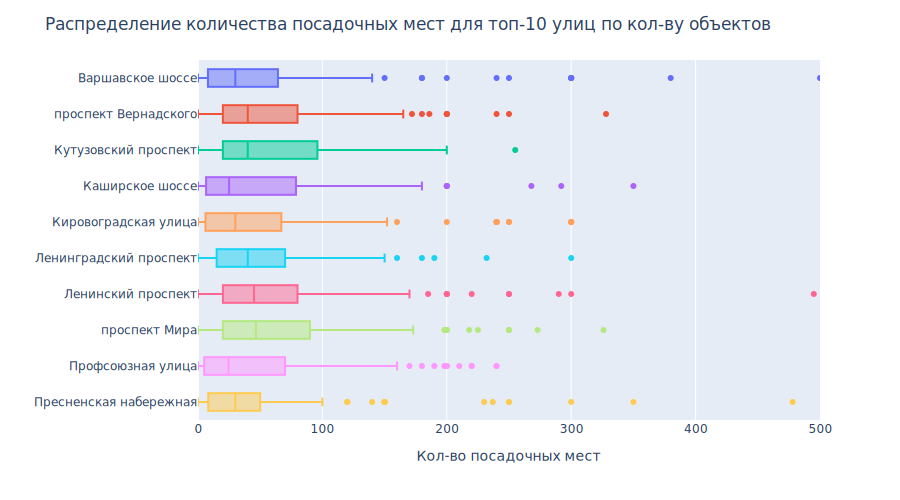

In [31]:
fig = px.box(top10_streets_data, x="number",
             y="street", color='street', width=900)
fig.update_layout(title='Распределение количества посадочных мест для топ-10 улиц по кол-ву объектов',
                  xaxis_title='Кол-во посадочных мест',
                  yaxis_title='',
                  xaxis_range=[0, 500]
                  )
fig.update(layout_showlegend=False)
fig.show("svg")

In [30]:
print('Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: {}'\
      .format(top10_streets_data['number'].median()))
print('Среднее кол-во посадочных мест в заведениях НЕ на топ-10 улицах по количеству объектов: {}'\
.format(df.query('street not in @top10_streets_list')['number'].median()))

Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: 40.0
Среднее кол-во посадочных мест в заведениях НЕ на топ-10 улицах по количеству объектов: 40.0


# Общий вывод

- Мы выяснили, что наибольшее количество типов объектов общественного питания составляют кафе 47.1%, предприятия быстро обслуживания 26.6%, рестораны 18.3%.
- При этом сетевых заведений лишь 19.4% от общего количества, остальные 80.6% - несетевые. Как правило для сетевых заведений характерно - мало заведений с большим количеством посадочных мест. В 95% сетей не больше 154 посадочных мест и 12 заведений в среднем.
- Максимальное количество посадочных мест характерно для столовых - 130 мест, у ресторанов 97 мест. У остальных значительно меньшее количество.

Топ-10 улиц с наибольшим количеством заведений:
 - проспект Мира - 204
 - Профсоюзная улица - 182
 - Ленинградский проспект - 172
 - Пресненская набережная - 167
 - Варшавское шоссе - 165
 - Ленинский проспект - 148
 - проспект Вернадского - 128
 - Кутузовский проспект - 114
 - Каширское шоссе - 111
 - Кировоградская улица - 108
 
Так же у нас есть список районов, в которых располагаются топ-10 улиц по кол-ву объектов общественного питания. Всего улиц с одним объектом общественного питания: 551, что составляет 28.9% от всего кол-ва улиц с объектами общественного питания в Москве.

Среднее кол-во посадочных мест в заведениях на топ-10 улицах по количеству объектов: 40.0 Среднее кол-во посадочных мест в заведениях НЕ на топ-10 улицах по количеству объектов: 40.0

**Рекомендации**

Можно отталкиваться от того, что на рынке более популярны кафе, потому именно такой тип заведения и рекомендовать со средним количеством посадочных мест на 30 персон. Касаемо района и улиц, то предполагаем что объект лучше размещать на одной из топ-10 улиц, ведь не спроста на этих улицах наибольшее количество объектов. Плюс непонятно, в какие сроки инвесторы хотят отбить свои первоначальные вложения. Как правило рестораны отбиваются дольше. 

Если бы мы использовали api яндекс геокодера, то смогли бы расположить все заведения на карте и общая картина была бы видна лучше. Желательно учитывать по текущим объектам расстояния до метро, какое метро, средние чеки в заведениях. (посмотреть зависимость среднего чека от типов объекта, расстояния от метро, расположениях в топовых районах). Так же желательно выделить наиболеее интересные здания для размещения заведений - высотки, исторические здания, топовые отели и гостиницы.